## Toy Regression Problem

### Dependencies

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import posteriors.nuqls as nuqls
from importlib import reload
import posteriors.swag as swag

torch.set_default_dtype(torch.float64)

### Create toy data

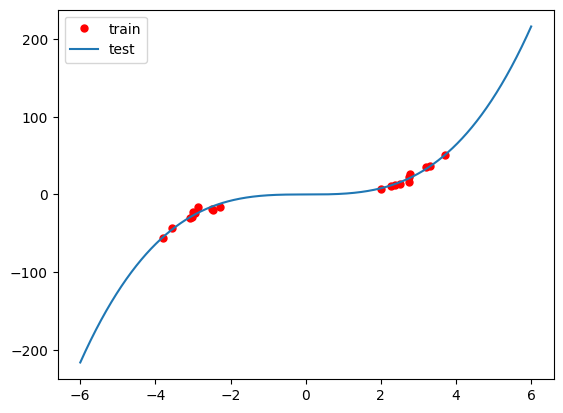

In [2]:
NUM_TRAIN_POINTS = 20
NUM_TEST_POINTS = 10000
std = 3
a1,a2,b1,b2 = -4,-2,2,4
c1,c2 = -6,6
eps = torch.randn((NUM_TRAIN_POINTS),1)*std
train_x = torch.cat((
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (a2-a1) + a1,
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (b2-b1) + b1
),dim=0)
train_y = torch.pow(train_x,3) + eps

train_y_std = train_y.std()
train_y_mean = train_y.mean()

test_x = torch.linspace(c1,c2,NUM_TEST_POINTS).reshape(-1,1)
test_y = torch.pow(test_x,3).reshape(-1,1)

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),label='test')
plt.legend()
plt.show()

In [3]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),NUM_TRAIN_POINTS)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),NUM_TEST_POINTS)

Using cpu device


  3%|▎         | 258/10000 [00:00<00:03, 2557.78it/s]

Train loss = 798.3697496553075


 13%|█▎        | 1295/10000 [00:00<00:02, 3377.81it/s]

Train loss = 81.45468742605604


 24%|██▍       | 2408/10000 [00:00<00:02, 3595.77it/s]

Train loss = 60.68215613796779


 35%|███▌      | 3518/10000 [00:01<00:01, 3657.59it/s]

Train loss = 35.23348320402161


 47%|████▋     | 4678/10000 [00:01<00:01, 3676.26it/s]

Train loss = 19.628548185018623


 55%|█████▍    | 5473/10000 [00:01<00:01, 3686.66it/s]

Train loss = 14.3746504945636


 66%|██████▋   | 6625/10000 [00:01<00:00, 3648.86it/s]

Train loss = 12.255786463400737


 77%|███████▋  | 7730/10000 [00:02<00:00, 3613.83it/s]

Train loss = 10.75587719864192


 85%|████████▍ | 8487/10000 [00:02<00:00, 3601.15it/s]

Train loss = 9.68221975974978


 96%|█████████▌| 9586/10000 [00:02<00:00, 3647.41it/s]

Train loss = 8.907320164451928


100%|██████████| 10000/10000 [00:02<00:00, 3585.38it/s]

Done!


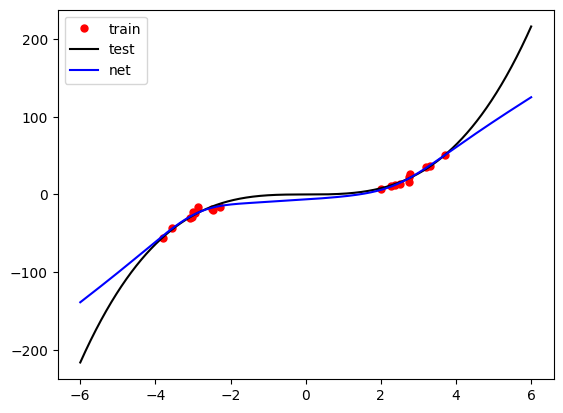

In [4]:
# Get cpu, gpu or mps device for training.
import utils.training


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
width = 50

class oneLayerMLP(torch.nn.Module):
    def __init__(self, width):
        super().__init__()
        self.output_size = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output
    

## MSE Model
map_net = oneLayerMLP(width).to(device)
map_net.apply(utils.training.weights_init_ff)

map_epochs = 10000
map_lr = 0.001
map_wd = 0

mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item()

def test(X, y, model, loss_fn):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    return loss.item()

train_MSE = True
if train_MSE:
    for t in tqdm(range(map_epochs)):
        train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)
        if t % (map_epochs / 10) == 0:
            print("Train loss = {}".format(train_loss))
    print("Done!")

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),'k',label='test')
plt.plot(test_x.cpu().numpy().reshape(-1), map_net(test_x).detach().cpu().numpy().reshape(-1), 'b', label='net')
plt.legend()
plt.show()

In [5]:
## NUQLS
reload(nuqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuql_test_preds, res = nuqls.series_method(map_net, train_data, test_data, ood_test_data=None, 
                                             regression= 'True', train_bs = 100, test_bs = 100, 
                                             S = 10, scale=5, lr=1e-3, epochs=1000, mu=0.9, 
                                             verbose=False)
nuql_mu = nuql_test_preds.mean(0)
nuql_var = nuql_test_preds.var(0)
print(res)

c:\Users\s4531973\Documents\PhD\Code\nuqls\posteriors\nuqls.py:239: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional_with_buffers` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params, buffers = make_functional_with_buffers(net)
  0%|          | 0/10 [00:00<?, ?it/s]

100


 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

loss = 7.664637891039112


 20%|██        | 2/10 [00:01<00:06,  1.18it/s]

loss = 8.048174794395909


 30%|███       | 3/10 [00:02<00:05,  1.20it/s]

loss = 8.124207286472213


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

{'loss': tensor(8.1242, grad_fn=<DivBackward0>), 'acc': 0}


In [8]:
## NUQLS parallel
reload(nuqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuql_test_preds,_ = nuqls.regression_parallel(map_net, train=train_data, test=test_data, ood_test=None, train_bs = 5, test_bs = 100, 
                                             S = 10, scale=5, lr=1e-4, epochs=1000, mu=0.9, verbose=True)
nuql_mu2 = nuql_test_preds.mean(1)
nuql_var2 = nuql_test_preds.var(1)

c:\Users\s4531973\Documents\PhD\Code\nuqls\posteriors\nuqls.py:356: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)
  2%|▏         | 20/1000 [00:00<00:05, 193.44it/s]

--------------- training ---------------
    epoch    |    loss    |    grad     
----------------------------------------
    0    |    8.67e+03    |    2.74e+04     
----------------------------------------
    10    |    3.85e+02    |    4.36e+02     
----------------------------------------
    20    |    91.9    |    67.2     
----------------------------------------
    30    |    44.9    |    31.3     
----------------------------------------


  6%|▌         | 60/1000 [00:00<00:04, 190.75it/s]

    40    |    30.1    |    17.5     
----------------------------------------
    50    |    23.4    |    10.6     
----------------------------------------
    60    |    19.9    |    6.91     
----------------------------------------
    70    |    18.0    |    4.92     
----------------------------------------


 10%|█         | 102/1000 [00:00<00:04, 182.96it/s]

    80    |    17.0    |    3.82     
----------------------------------------
    90    |    16.4    |    3.21     
----------------------------------------
    100    |    16.1    |    2.86     
----------------------------------------
    110    |    15.8    |    2.66     
----------------------------------------


 16%|█▋        | 163/1000 [00:00<00:04, 193.85it/s]

    120    |    15.7    |    2.54     
----------------------------------------
    130    |    15.5    |    2.47     
----------------------------------------
    140    |    15.4    |    2.42     
----------------------------------------
    150    |    15.3    |    2.39     
----------------------------------------
    160    |    15.3    |    2.37     
----------------------------------------


 20%|██        | 203/1000 [00:01<00:04, 195.40it/s]

    170    |    15.2    |    2.35     
----------------------------------------
    180    |    15.1    |    2.34     
----------------------------------------
    190    |    15.0    |    2.33     
----------------------------------------
    200    |    14.9    |    2.32     
----------------------------------------
    210    |    14.9    |    2.31     
----------------------------------------


 25%|██▍       | 246/1000 [00:01<00:03, 197.15it/s]

    220    |    14.8    |    2.3     
----------------------------------------
    230    |    14.7    |    2.29     
----------------------------------------
    240    |    14.6    |    2.29     
----------------------------------------
    250    |    14.6    |    2.28     
----------------------------------------
    260    |    14.5    |    2.27     
----------------------------------------


 29%|██▉       | 289/1000 [00:01<00:03, 196.64it/s]

    270    |    14.4    |    2.27     
----------------------------------------
    280    |    14.3    |    2.26     
----------------------------------------
    290    |    14.3    |    2.25     
----------------------------------------
    300    |    14.2    |    2.25     
----------------------------------------


 33%|███▎      | 330/1000 [00:01<00:03, 194.10it/s]

    310    |    14.1    |    2.24     
----------------------------------------
    320    |    14.1    |    2.24     
----------------------------------------
    330    |    14.0    |    2.23     
----------------------------------------
    340    |    13.9    |    2.22     
----------------------------------------


 37%|███▋      | 374/1000 [00:01<00:03, 196.76it/s]

    350    |    13.9    |    2.22     
----------------------------------------
    360    |    13.8    |    2.21     
----------------------------------------
    370    |    13.7    |    2.21     
----------------------------------------
    380    |    13.7    |    2.2     
----------------------------------------


 42%|████▏     | 418/1000 [00:02<00:02, 199.36it/s]

    390    |    13.6    |    2.2     
----------------------------------------
    400    |    13.5    |    2.19     
----------------------------------------
    410    |    13.5    |    2.19     
----------------------------------------
    420    |    13.4    |    2.18     
----------------------------------------


 46%|████▌     | 458/1000 [00:02<00:02, 198.16it/s]

    430    |    13.4    |    2.18     
----------------------------------------
    440    |    13.3    |    2.17     
----------------------------------------
    450    |    13.2    |    2.17     
----------------------------------------
    460    |    13.2    |    2.16     
----------------------------------------


 50%|████▉     | 498/1000 [00:02<00:02, 197.59it/s]

    470    |    13.1    |    2.16     
----------------------------------------
    480    |    13.1    |    2.15     
----------------------------------------
    490    |    13.0    |    2.15     
----------------------------------------
    500    |    12.9    |    2.14     
----------------------------------------
    510    |    12.9    |    2.14     
----------------------------------------


 54%|█████▍    | 543/1000 [00:02<00:02, 198.77it/s]

    520    |    12.8    |    2.13     
----------------------------------------
    530    |    12.8    |    2.13     
----------------------------------------
    540    |    12.7    |    2.12     
----------------------------------------
    550    |    12.7    |    2.12     
----------------------------------------
    560    |    12.6    |    2.11     
----------------------------------------


 60%|██████    | 603/1000 [00:03<00:01, 199.48it/s]

    570    |    12.6    |    2.11     
----------------------------------------
    580    |    12.5    |    2.1     
----------------------------------------
    590    |    12.5    |    2.1     
----------------------------------------
    600    |    12.4    |    2.1     
----------------------------------------


 64%|██████▍   | 643/1000 [00:03<00:01, 191.35it/s]

    610    |    12.4    |    2.09     
----------------------------------------
    620    |    12.3    |    2.09     
----------------------------------------
    630    |    12.3    |    2.08     
----------------------------------------
    640    |    12.2    |    2.08     
----------------------------------------


 68%|██████▊   | 683/1000 [00:03<00:01, 193.75it/s]

    650    |    12.2    |    2.07     
----------------------------------------
    660    |    12.1    |    2.07     
----------------------------------------
    670    |    12.1    |    2.07     
----------------------------------------
    680    |    12.0    |    2.06     
----------------------------------------
    690    |    12.0    |    2.06     
----------------------------------------


 72%|███████▏  | 724/1000 [00:03<00:01, 196.41it/s]

    700    |    11.9    |    2.05     
----------------------------------------
    710    |    11.9    |    2.05     
----------------------------------------
    720    |    11.8    |    2.05     
----------------------------------------
    730    |    11.8    |    2.04     
----------------------------------------
    740    |    11.8    |    2.04     
----------------------------------------


 79%|███████▊  | 787/1000 [00:04<00:01, 197.44it/s]

    750    |    11.7    |    2.03     
----------------------------------------
    760    |    11.7    |    2.03     
----------------------------------------
    770    |    11.6    |    2.03     
----------------------------------------
    780    |    11.6    |    2.02     
----------------------------------------
    790    |    11.5    |    2.02     
----------------------------------------


 83%|████████▎ | 829/1000 [00:04<00:00, 196.71it/s]

    800    |    11.5    |    2.02     
----------------------------------------
    810    |    11.5    |    2.01     
----------------------------------------
    820    |    11.4    |    2.01     
----------------------------------------
    830    |    11.4    |    2.0     
----------------------------------------
    840    |    11.3    |    2.0     
----------------------------------------


 89%|████████▉ | 890/1000 [00:04<00:00, 197.83it/s]

    850    |    11.3    |    2.0     
----------------------------------------
    860    |    11.3    |    1.99     
----------------------------------------
    870    |    11.2    |    1.99     
----------------------------------------
    880    |    11.2    |    1.99     
----------------------------------------


 93%|█████████▎| 930/1000 [00:04<00:00, 196.79it/s]

    890    |    11.2    |    1.98     
----------------------------------------
    900    |    11.1    |    1.98     
----------------------------------------
    910    |    11.1    |    1.98     
----------------------------------------
    920    |    11.0    |    1.97     
----------------------------------------


 97%|█████████▋| 970/1000 [00:04<00:00, 196.98it/s]

    930    |    11.0    |    1.97     
----------------------------------------
    940    |    11.0    |    1.97     
----------------------------------------
    950    |    10.9    |    1.96     
----------------------------------------
    960    |    10.9    |    1.96     
----------------------------------------


100%|██████████| 1000/1000 [00:05<00:00, 195.67it/s]


    970    |    10.9    |    1.96     
----------------------------------------
    980    |    10.8    |    1.96     
----------------------------------------
    990    |    10.8    |    1.95     
----------------------------------------


In [9]:
## DE - Heteroskedastic Variance
WIDTH = width

def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(1,WIDTH)
        self.relu = torch.nn.SiLU()
        self.linear_mu = torch.nn.Linear(WIDTH,1)
        self.linear_sig = torch.nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = torch.nn.functional.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(torch.nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

S = 10
de_lr = 0.05
de_epochs = 2000
de_wd = 0

model_list = []
opt_list = []
sched_list = []

for i in range(S):
    model_list.append(EnsembleNetwork().to(device))
    model_list[i].apply(utils.training.weights_init_ff)
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = de_lr, weight_decay=de_wd))
    sched_list.append(torch.optim.lr_scheduler.PolynomialLR(opt_list[i], de_epochs, 0.5))

NLL = CustomNLL()

def train_heteroskedastic(X,y,net,loss,optim,sched):
    # Compute prediction error
    pred, var = net(X)
    loss = loss(y, pred, var)

    # Backpropagation
    loss.backward()

    optim.step()
    # sched.step()
    optim.zero_grad()

    return loss.item()

train_ensembles = True
if train_ensembles:
    for i in range(S):
        print("\nTraining model {}".format(i))
        for t in range(de_epochs):
            train_loss = train_heteroskedastic(train_x, train_y, model_list[i], NLL, opt_list[i], sched_list[i])
            if t % (de_epochs / 10) == 0:
                print("NLL loss = {}".format(train_loss))
                test_pred,test_var = model_list[i](train_x)
                mle_loss = mse_loss(test_pred,train_y)
                print("MSE loss = {}".format(mle_loss))
        print("Done!")

ensemble_het_mu = torch.empty((S,NUM_TEST_POINTS))
ensemble_het_var = torch.empty((S,NUM_TEST_POINTS))
for i in range(S):
    mu, var = model_list[i](test_x)
    ensemble_het_mu[i,:] = mu.reshape(1,-1)
    ensemble_het_var[i,:] = var.reshape(1,-1)
ensemble_het_mu_mean = torch.mean(ensemble_het_mu,dim=0)
ensemble_het_var_mean = torch.mean(ensemble_het_var + torch.square(ensemble_het_mu), dim=0) - torch.square(ensemble_het_mu_mean)


Training model 0
NLL loss = 357.98103016544553
MSE loss = 772.7348698199185
NLL loss = 3.9349142630657155
MSE loss = 81.57742330577369
NLL loss = 3.602420862656621
MSE loss = 66.99320270069731
NLL loss = 3.3417996484133274
MSE loss = 50.286162602444406
NLL loss = 3.143137719268041
MSE loss = 38.34964771661517
NLL loss = 2.927925145971667
MSE loss = 28.843896648062508
NLL loss = 2.799113916316452
MSE loss = 17.92213325738827
NLL loss = 2.680367859392256
MSE loss = 12.138161609106756
NLL loss = 2.4823254718411785
MSE loss = 7.2367740229625905
NLL loss = 2.453956061681088
MSE loss = 6.9661527507576535
Done!

Training model 1
NLL loss = 589.952001439289
MSE loss = 738.4508435471804
NLL loss = 4.354744024157613
MSE loss = 87.0730805362324
NLL loss = 3.7282105421649567
MSE loss = 65.52780860390789
NLL loss = 3.254536863092472
MSE loss = 37.880678095062954
NLL loss = 2.903206251425759
MSE loss = 14.522008260058755
NLL loss = 2.7446241331585695
MSE loss = 8.155078998387868
NLL loss = 2.641603

In [11]:
## SWAG
reload(swag)

swag_net = oneLayerMLP(width).to(device)
swag_net.apply(utils.training.weights_init_ff)

optimizer_MSE = torch.optim.Adam(swag_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in tqdm(range(map_epochs)):
    train_loss = train(train_x, train_y, swag_net, mse_loss, optimizer_MSE, scheduler_MSE)
    if t % (map_epochs / 10) == 0:
        print("Train loss = {}".format(train_loss))
print("Done!")

swag_method = swag.SWAG_R(swag_net,epochs = map_epochs, lr = map_lr, cov_mat = True,
                            max_num_models=10)
swag_method.train_swag(train_loader=toy_train_loader, weight_decay=0)

T = 1000
swag_pred_samples = torch.empty((T,NUM_TEST_POINTS),device='cpu')
for t in range(T):
    swag_method.sample(cov=True)
    swag_pred_samples[t,:] = swag_method(test_x).reshape(-1)
swag_pred = swag_pred_samples.mean(axis=0)
swag_var = swag_pred_samples.var(axis=0)

  7%|▋         | 717/10000 [00:00<00:02, 3524.47it/s]

Train loss = 787.4925715693344


 15%|█▍        | 1469/10000 [00:00<00:02, 3503.34it/s]

Train loss = 75.45455150662777


 26%|██▌       | 2587/10000 [00:00<00:02, 3533.74it/s]

Train loss = 52.23473058079702


 33%|███▎      | 3293/10000 [00:00<00:01, 3483.91it/s]

Train loss = 30.425207310126023


 44%|████▎     | 4363/10000 [00:01<00:01, 3461.98it/s]

Train loss = 17.472163457157524


 54%|█████▍    | 5412/10000 [00:01<00:01, 3472.68it/s]

Train loss = 14.178682053585225


 65%|██████▌   | 6531/10000 [00:01<00:00, 3520.96it/s]

Train loss = 12.844979392986057


 72%|███████▎  | 7250/10000 [00:02<00:00, 3404.76it/s]

Train loss = 11.655037635491855


 84%|████████▎ | 8368/10000 [00:02<00:00, 3486.67it/s]

Train loss = 10.543902817829684


 95%|█████████▍| 9465/10000 [00:02<00:00, 3481.78it/s]

Train loss = 9.651262132449343


100%|██████████| 10000/10000 [00:02<00:00, 3479.57it/s]


Done!


In [27]:
## LLA
from posteriors.lla.likelihoods import GaussianLh
from posteriors.lla.laplace import Laplace

prior_prec = 0.028
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LLA
mu_glm_full, var_glm_full = get_pred_for('glm', 'full')



c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.oneLayerMLP'> although the module has parameters
  warnings.warn(


In [13]:
## LA
prior_prec = 1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LA
mu_bnn_full, var_bnn_full = get_pred_for('bnn', 'full')

In [14]:
# VI
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 3.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

vi_net = deepcopy(map_net)
    
dnn_to_bnn(vi_net, const_bnn_prior_parameters)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vi_net.parameters(), 1e-3, weight_decay=0)

for _ in range(10000):
    output = vi_net(train_x)
    kl = get_kl_loss(vi_net)
    ce_loss = criterion(output, train_y)
    loss = ce_loss + kl

    loss.backward()
    optimizer.step()
    print(f"loss = {loss}")

vi_net.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(1000):
        output = vi_net(test_x)
        output_mc.append(output)
    output = torch.stack(output_mc)  
    mu_vi = output.mean(0)
    var_vi = output.var(0)


loss = 808.491924698468
loss = 813.8608361461431
loss = 806.839358382778
loss = 814.822624624802
loss = 808.054674050466
loss = 804.897939656737
loss = 810.1565872033755
loss = 807.0374246916705
loss = 804.6267530210955
loss = 807.298391607624
loss = 804.7976657248073
loss = 803.3257672046133
loss = 806.2979238844769
loss = 803.6868164743269
loss = 794.1023294855328
loss = 797.6681919862425
loss = 805.1542178610778
loss = 797.0339012529407
loss = 798.5337005190519
loss = 803.1542580462685
loss = 795.5797918008745
loss = 798.6839794404253
loss = 798.1125393178647
loss = 786.7181858774966
loss = 802.7406642438975
loss = 788.903054717418
loss = 793.0394841408968
loss = 791.7760616600892
loss = 794.2423387280139
loss = 791.1676814675263
loss = 784.5122012399584
loss = 790.9566868704734
loss = 788.2450299824612
loss = 786.8746716486872
loss = 773.271491675686
loss = 777.2735897565019
loss = 784.7302689123258
loss = 776.390424479225
loss = 780.3380570356111
loss = 782.2285216311534
loss = 77

In [15]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw, legend_true=False):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms, label='Training data')
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw, label='Target curve')
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw, label='Mean prediction')

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4, label='$3\sigma$')

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)

    if legend_true:
        ax.legend()


In [14]:
## Sampling LLA
from functorch import make_functional
from torch.func import vmap, jacrev

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

fnet, params = make_functional(map_net)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)
J = vmap(jacrev(fnet_single), (None, 0))(params, train_x.to(device))
J = [j.detach().flatten(1) for j in J]
J = torch.cat(J,dim=1).detach()
n, p = J.shape

theta_t = flatten(params)

S = 10
beta = 3
alpha = 0.01
lr = 2e-4
epochs = 10000
zeta = torch.empty((p,S), requires_grad=False)
zeta_exact = torch.empty((p,S), requires_grad=False)

print(f'---- parameter samples ----')
for s in range(S):
    Eps = torch.randn((n), requires_grad=False) * (beta)**(-0.5)
    theta0 = torch.randn((p), requires_grad=False) * (alpha)**(-0.5)

    # SGD
    # L = lambda z : 0.5 * beta * (J @ z - Eps).T @ (J @ z - Eps) + 0.5 * alpha * (z - theta0).T @ (z - theta0)
    L = lambda z : 0.5 * beta * (J @ z).T @ (J @ z) + 0.5 * alpha * (z - theta0 - beta/alpha * J.T @ Eps).T @ (z - theta0 - beta/alpha * J.T @ Eps)
    z = torch.nn.parameter.Parameter(theta0)
    optim = torch.optim.SGD([z],lr=lr, momentum=0.9)
    for i in range(epochs):
        loss = L(z)
        loss.backward()
        optim.step()
        optim.zero_grad()
    zeta[:,s] = z.detach()
    print(f'sample {s}, loss = {loss.item():.4}')

    # Exact
    with torch.no_grad():
        zeta_exact[:,s] = torch.linalg.solve(beta * J.T @ J + alpha * torch.eye(p), alpha * theta0 + beta * J.T @ Eps).detach()

    print(f'difference = {torch.linalg.norm(zeta[:,s] - zeta_exact[:,s])}')

J = vmap(jacrev(fnet_single), (None, 0))(params, test_x.to(device))
J = [j.detach().flatten(1) for j in J]
J = torch.cat(J,dim=1).detach()
n, p = J.shape

with torch.no_grad():
    pred_s = []
    f_nlin = map_net(test_x)
    for s in range(S):
        pred_lin = J @ (zeta[:,s] - theta_t) + f_nlin.squeeze(1)
        pred_s.append(pred_lin)

pred_lla = torch.stack(pred_s)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_6080\549817684.py:9: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(map_net)


---- parameter samples ----
sample 0, loss = nan
difference = nan
sample 1, loss = nan
difference = nan


KeyboardInterrupt: 

In [31]:
import posteriors.lla_s as lla_s
from importlib import reload
reload(lla_s)
pred_lla, res = lla_s.small_regression_parallel(net = map_net, train=train_data, test=test_data,
                            S = 100, epochs=10000, lr=5e-5, epochs_mode=1000, lr_mode=1e-2, 
                            alpha0=0.01, alpha_it=10, beta=3, exact=True, verbose=False)
print(res)

c:\Users\s4531973\Documents\PhD\Code\nuqls\posteriors\lla_s.py:145: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)
  0%|          | 0/10 [00:00<?, ?it/s]

Alpha = 0.01


 10%|█         | 1/10 [00:09<01:26,  9.58s/it]

Alpha = 0.054263831471989675


 20%|██        | 2/10 [00:19<01:17,  9.65s/it]

Alpha = 0.0346800045882637


 30%|███       | 3/10 [00:29<01:08,  9.79s/it]

Alpha = 0.027734803669884307


 40%|████      | 4/10 [00:38<00:58,  9.72s/it]

Alpha = 0.02531663922744384


 50%|█████     | 5/10 [00:48<00:48,  9.66s/it]

Alpha = 0.02637212126854692


 60%|██████    | 6/10 [00:58<00:38,  9.64s/it]

Alpha = 0.026713485431280343


 70%|███████   | 7/10 [01:07<00:28,  9.60s/it]

Alpha = 0.02606934052695944


 80%|████████  | 8/10 [01:17<00:19,  9.59s/it]

Alpha = 0.025059340601500654


 90%|█████████ | 9/10 [01:26<00:09,  9.67s/it]

Alpha = 0.023654786069534098


100%|██████████| 10/10 [01:36<00:00,  9.63s/it]


{'sample_loss': [], 'mode_loss': [12.859885473310593, 10.000870805072305, 8.67259610930435, 8.128719747229995, 7.899761080353609, 7.8407069630447825, 7.817990143133382, 7.785957211513346, 7.744282730153353, 7.692079974767471]}


In [21]:
mu_glm_full.shape

torch.Size([10000, 1])

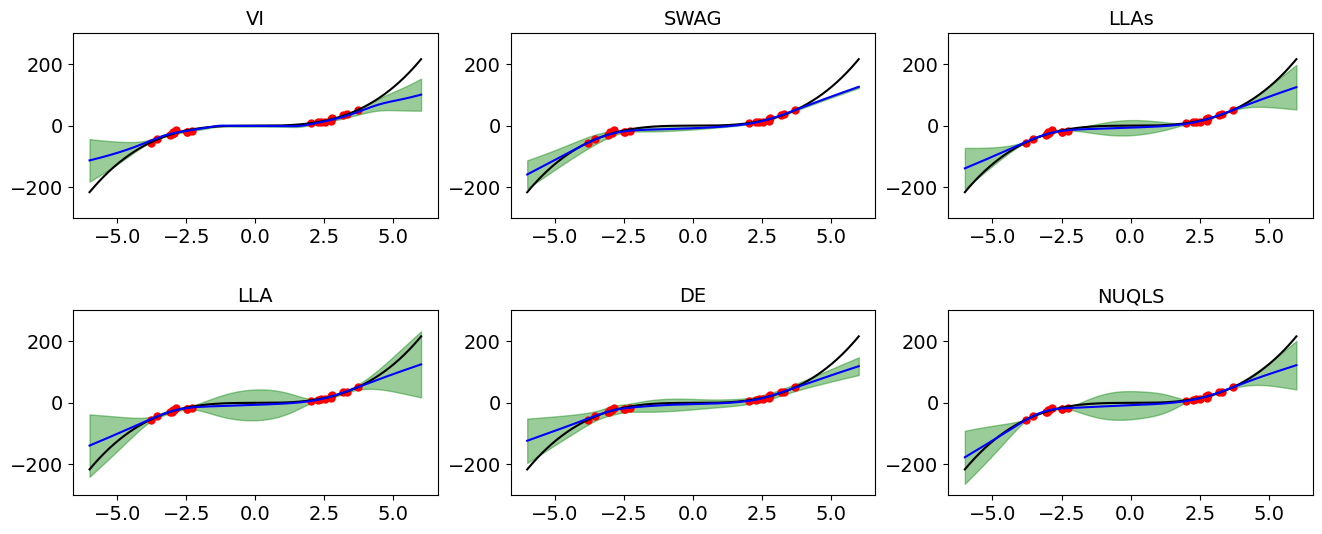

In [32]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

f.set_figheight(6)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot VI
plot_bayes_method(ax1,mu_vi,var_vi,'VI',fs=fs, ms=ms, lw=lw)

## Plot SWAG
plot_bayes_method(ax2,swag_pred,swag_var,'SWAG',fs=fs, ms=ms, lw=lw)

## LA
# # plot_bayes_method(ax3,mu_bnn_full,var_bnn_full,'LA',fs=fs, ms=ms, lw=lw)
plot_bayes_method(ax3,mu_glm_full.squeeze(1),pred_lla.var(0),'LLAs',fs=fs, ms=ms, lw=lw)
# plot_bayes_method(ax3,nuql_mu2,nuql_var2,'NUQLS2',fs=fs, ms=ms, lw=lw)

## Plot LLA
plot_bayes_method(ax4,mu_glm_full,var_glm_full,'LLA',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax5,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax6,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
swag_var.shape

In [ ]:

pred_lla.shape

In [ ]:
# BDE
from functorch import make_functional
from torch.func import vmap, jacrev

def l_layer_params(net):
    theta_star_k = []
    sd = net.state_dict()
    sdk = sd.keys()
    print(len(sdk))
    for i,p in enumerate(sdk):
        if i < len(sdk) - 2:
            theta_star_k.append(sd[p].flatten(0))
        else:
            theta_star_k.append(torch.zeros(sd[p].flatten(0).shape))
    theta_star_k = torch.cat(theta_star_k)
    return theta_star_k

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

M = 10
learning_rate = 0.01
epochs = 10000
weight_decay = 0
sigma2 = std**2

model_list = []
opt_list = []
sched_list = []

loss = mse_loss
bde_preds = torch.empty((M,NUM_TEST_POINTS))

def train_bde(X,y,net,delta,theta_k,loss,Lambda,optim,sched):
    # Compute prediction error
    pred = net(X)

    # Add delta function to outputs
    pred = pred + delta

    # Calculate loss
    loss = loss(y, pred)

    # Regularisation
    theta_t = torch.nn.utils.parameters_to_vector(net.parameters())
    diff = theta_t - theta_k
    reg = diff @ (Lambda * diff)
    loss = 0.5 * loss + 0.5 * reg

    # Backpropagation
    loss.backward()

    optim.step()
    if sched is not None:
        sched.step()
    optim.zero_grad()

    return loss.item()

def bde_weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias,mean=0,std=1)

for i in range(M):
    bde_model1 = oneLayerMLP(width).to(device)
    bde_model1.apply(bde_weights_init)
    opt = torch.optim.Adam(bde_model1.parameters(), lr = map_lr, weight_decay=map_wd)
    sched = torch.optim.lr_scheduler.PolynomialLR(opt, map_epochs, 0.5)

    ## Find theta~
    bde_model2 = oneLayerMLP(width).to(device)
    bde_model2.apply(utils.training.weights_init_ff) 
    theta_star_k = l_layer_params(bde_model2)

    ## Create delta functions
    fnet, params = make_functional(bde_model1)
    def jacobian(x):
        def fnet_single(params, x):
            return fnet(params, x.unsqueeze(0)).squeeze(0)
        J = vmap(jacrev(fnet_single), (None, 0))(params, x.to(device))
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J
    delta = lambda x : jacobian(x) @ theta_star_k
    train_delta = delta(train_x)

    ## Save theta_k
    theta_k = torch.nn.utils.parameters_to_vector(bde_model1.parameters()).detach().clone()

    ## Create Mahalanobis matrix
    Lambda = 1 / sigma2

    ## Train ensemble member
    print("\nTraining model {}".format(i))
    for t in tqdm(range(map_epochs)):
        train_loss = train_bde(train_x, train_y, bde_model1, train_delta, theta_k, mse_loss, Lambda, opt, sched)
        if t % (epochs / 10) == 0:
            print("train loss = {:.4f}".format(train_loss))
    print("Done!")

    # Get predictions
    bde_pred = bde_model1(test_x).reshape(-1) + delta(test_x).reshape(-1)
    bde_preds[i,:] = bde_pred

bde_mean = torch.mean(bde_preds,dim=0)
bde_var = torch.var(bde_preds,dim=0)  + std**2

In [ ]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, (ax1,ax2,ax3) = plt.subplots(1,3)

f.set_figheight(3)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot BDE
plot_bayes_method(ax1,bde_mean,bde_var,'BDE',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax2,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax3,nuql_mu,nuql_var,'NUQLS',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison_bde.pdf", format="pdf", bbox_inches="tight")
plt.show()